## Parametric Survival Analysis

This notebook explores the training and validation of parametric models using SurvivalNet.

Parametric models generate individualized survival distributions that describe the likelihood of outcomes as a function of time and conditioned on the covariates of a sample. SurvivalNet implements several parametric distributions as losses that can be used for network training. For a parametric model the neural network predicts distribution parameters that control shape and scale which describe expected patient outcome. The predictions from parametric models can be used to estimate specific probabilities like five-year survival, and can be analyzed using statistics like the Brier score or d-calibration to measure model calibration.

Topics covered in this notebook:

1. Working with parametric losses (exponential, Weibull)
2. Using survival functions to analyze data
3. Improving numerical stability by normalizing time scales
4. Calibration metrics - Brier, integrated Brier, and d-calibration

References:
1. Rodriguez G. Parametric Survival Models [Internet]. Available from: https://data.princeton.edu/pop509/ParametricSurvival.pdf. 
2. Haider H, Hoehn B, Davis S, Greiner R. Effective Ways to Build and Evaluate Individual Survival Distributions. J. Mach. Learn. Res.. 2020 Jan 1;21(85):1-63.

In [1]:
import math
import numpy as np
import os
import pandas as pd
import sys

import tensorflow as tf
from tensorflow import math
from tensorflow.keras.activations import softplus

import survivalnet2
from survivalnet2.estimators import km, km_eval
from survivalnet2.losses import Exponential, Weibull
from survivalnet2.metrics.concordance import HarrellsC
from survivalnet2.metrics.brier import Brier, IntegratedBrier
from survivalnet2.metrics.dcal import Dcal
from survivalnet2.visualization import km_plot

import matplotlib.pyplot as plt

%matplotlib inline

# set seed for reproducibility
np.random.seed(51)
tf.random.set_seed(51)

### Load the data

A dataset contains features and labels. In this example, features are represented by an 565 x 412 matrix where each row contains the features for one patient. The labels contain both Overall Survival (OS) and Progression Free Interval (PFI), but we will focus on OS in this notebook. The OS is represented a 565 x 2 matrix, where the first column represents the event or last followup time (days), and the second column contains the event indicator (1 for samples where death was observed).

In [2]:
def load_example(file):
    # load example data, generate random train/test split
    data = pd.read_csv(file, index_col=0)

    # retrieve protein expression features
    features = data.iloc[13:, :].to_numpy().T

    # get outcomes
    osr = data.iloc[[6, 5], :].to_numpy().T
    pfi = data.iloc[[12, 11], :].to_numpy().T

    # convert types
    features = features.astype(np.float32)
    osr = osr.astype(np.float32)
    pfi = pfi.astype(np.float32)

    return features, osr, pfi


# add package install path to python
install_dir = os.path.dirname(os.path.dirname(survivalnet2.__file__))
sys.path.append(install_dir)

# load example data
data_path = os.path.join(install_dir, "examples/TCGA_glioma.csv")
features, osr, _ = load_example(data_path)

# get data shape
(N, D) = features.shape

### Remove samples with zero OS times and shuffle data

Samples where time=0 must be removed to avoid log(0) in the log hazard and survival functions which results in `nan` loss values. In this example dataset two samples are removed.

In [3]:
# remove samples with OS time == 0
mask = osr[:, 0] == 0
features = features[~mask]
osr = osr[~mask]

# shuffle data
idxs = np.random.permutation(len(features))
features, osr = features[idxs], osr[idxs]

### Scale the time axis to improve training stability

Time values are represented as days which range from zero to 6243. Large values can introduce numerical issues like underflows and exploding gradients during training. Scaling OS times is advisable to improve stability, so we divide by 365.25 to convert time units to years.

In [4]:
print("Current range for times (days):", min(osr[:, 0]), "-", max(osr[:, 0]))

# scale the data
scale = 365.25
osr[:, 0] = osr[:, 0] / scale

print("Scaled range for times (years):", min(osr[:, 0]), "-", max(osr[:, 0]))

Current range for times (days): 1.0 - 6423.0
Scaled range for times (years): 0.0027378509 - 17.585217


### Visualize empirical survival function

Let's start by visualizing the OS survival function for the entire dataset. An empirical survival function can be estimated using `survivalnet.estimators.km` and evaluated on a fine grid using `survivalnet.estimators.km_eval`. At the population level an exponential distribution fits the estimated survival function well.

Below we will train models that predict individualized survival functions that are conditioned on the features / covariates of each sample. While an exponential fits the population survival function well, it is not necessarily the best distribution for individualized survival functions.

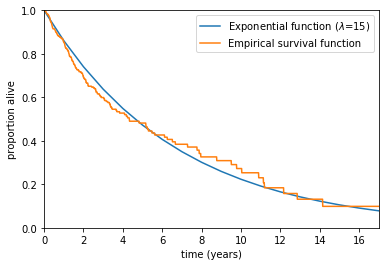

In [5]:
# estimate Kaplan-Meier curve and interpolate over a dense time axis
t, s = km(osr)
delta_t = 1e-2
t_max = int(max(osr[:, 0]))
t_dense = np.arange(0, t_max, delta_t).astype(np.float32)
s_dense = km_eval(t_dense, t, s)

# graph survival and exponential curves
plt.plot(np.exp(-15 * t_dense), label=r"Exponential function ($\lambda$=15)")
plt.plot(t_dense, s_dense, label="Empirical survival function")
plt.gca().set_ylabel("proportion alive")
plt.gca().set_xlabel("time (years)")
plt.xlim((0, t_max))
plt.ylim((0, 1))
plt.legend()
plt.show()

### Create a tf.data.Dataset for batching

After splitting the dataset into training and testing sets we wrap the training data in a `tf.data.Dataset` object to enable batching during training.

In [6]:
# generate train/test split
index = np.argsort(np.random.rand(features.shape[0]))
train = np.zeros(features.shape[0], np.bool_)
train[index[0 : int(0.8 * features.shape[0])].astype(np.int32)] = True
test = ~train

# create tf Dataset for Keras training
dataset = tf.data.Dataset.from_tensor_slices((features[train, :], osr[train, :]))

### Build and train an exponential model

To fit an exponential model we construct a simple two-layer network that outputs a single parameter *lambda*. Valid exponential survival functions require *lambda* to be strictly positive (>0), and so we use a `softplus` activation at the output. Most parametric models have restricted parameter domains and it is the responsibility of the user to constrain network outputs to satisfy these requirements. During training, we use metrics to monitor model discrimination and calibration (see below).

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


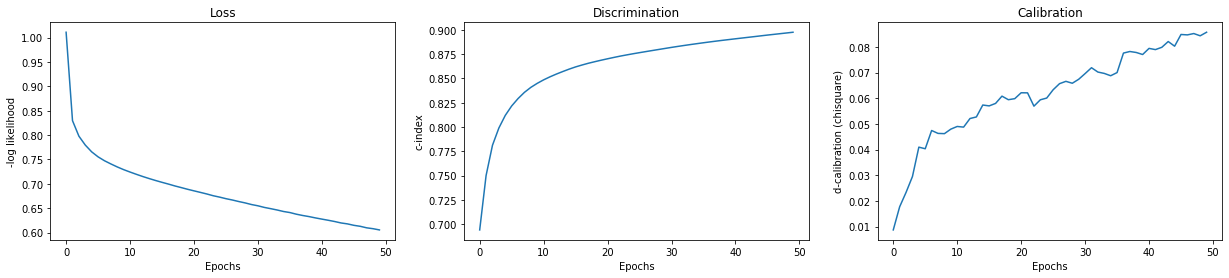

In [7]:
# this class contains the survival, hazard, and loss functions for the exponential model
exponential = Exponential()

# build a simple 2 layer model
inputs = tf.keras.Input((D,))
x = tf.keras.layers.Dense(units=10, activation="selu")(inputs)
parameters = tf.keras.layers.Dense(units=1, activation="softplus")(x)

# create keras model
exponential_model = tf.keras.Model(inputs=inputs, outputs=parameters)

# create metrics to measure discrimination and calibration
cindex = HarrellsC(name="ci_exponential")
dcal = Dcal(exponential.survival, name="dcal_exponential")

# compile model
exponential_model.compile(
    loss=exponential.negative_log_likelihood,
    metrics=[cindex, dcal],
    optimizer=tf.keras.optimizers.Adam(1e-3),
)

# train model
history = exponential_model.fit(x=dataset.batch(32), epochs=50, verbose=0).history


# visualize training performance
def graph_training_curves(plots):
    fig, axes = plt.subplots(1, len(plots), figsize=(7 * len(plots), 4))
    for axes, plot in zip(axes, plots):
        axes.set_title(plot[0])
        axes.set_ylabel(plot[1])
        axes.set_xlabel("Epochs")
        axes.plot(plot[2])
    plt.show()


graph_training_curves(
    [
        ["Loss", "-log likelihood", history["loss"]],
        ["Discrimination", "c-index", history["ci_exponential"]],
        ["Calibration", "d-calibration (chisquare)", history["dcal_exponential"]],
    ]
)

###  Build and train a Weibull model

The exponential distribution has a single parameter, and is a memoryless distribution with a constant hazard for all times. A Weibull distribution has independent *shape* and *scale* parameters that provide more flexibility in modeling survival functions. A network for a Weibull distribution will output two strictly positive parameters.

A high learning rate might cause numerical instability when training parametric models. If the model produces `nan` during training try reducing learning rate or use early stopping.

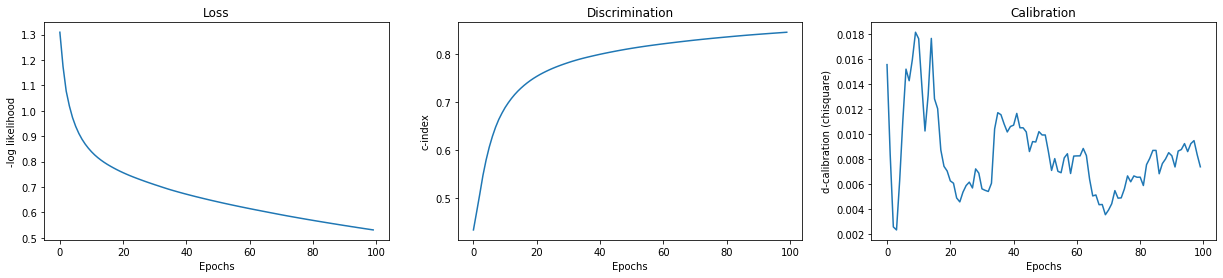

In [8]:
# contains survival, hazard, and loss functions
weibull = Weibull()

# build a simple 2 layer model that predicts two strictly positive parameters
inputs = tf.keras.Input((D,))
x = tf.keras.layers.Dense(units=10, activation="selu")(inputs)
parameters = tf.keras.layers.Dense(units=2, activation="softplus", name="parameters")(x)

# The Weibull model has two parameters so we generate a median survival output to measure
# discrimination. Here tf.keras.layers.Layer here is used as an identity / pass through
# operation to name this output.
nmedian = tf.keras.layers.Layer(name="median")(-weibull.median(parameters))

# create metrics to measure discrimination and calibration
cindex = HarrellsC(name="ci_weibull")
dcal = Dcal(weibull.survival, name="dcal_weibull")

# create keras model
weibull_model = tf.keras.Model(inputs=inputs, outputs=[parameters, nmedian])

# compile model - map the 1st output to Dcal metric, 2nd output to c-index metric
weibull_model.compile(
    loss={"parameters": weibull.negative_log_likelihood},
    metrics=[[dcal], [cindex]],
    optimizer=tf.keras.optimizers.Adam(1e-4),
)

# train model, this might take a minute or two
history = weibull_model.fit(x=dataset.batch(32), epochs=100, verbose=0).history

# display training history
graph_training_curves(
    [
        ["Loss", "-log likelihood", history["loss"]],
        ["Discrimination", "c-index", history["median_ci_weibull"]],
        [
            "Calibration",
            "d-calibration (chisquare)",
            history["parameters_dcal_weibull"],
        ],
    ]
)

### Analyzing individualized survival functions

The survival distributions generated by parametric models can be analyzed to determine the probability of specific events, like 5-year survival probabilitiy or expected survival. The parametic loss classes in `survivalnet.losses` provide functions like `.survival` and `.hazard` that can evalute an individualized survival or hazard functions given a predicted parameter and one or more times.

The plots below compare the exponential and Weibull individualized survival functions for two samples taken from the the upper and lower range of outcomes. Distributions for the poor prognosis sample have shorter tails and are very similar. For the good prognosis sample the impact of the Weibull shape parameter is more evident.

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays 

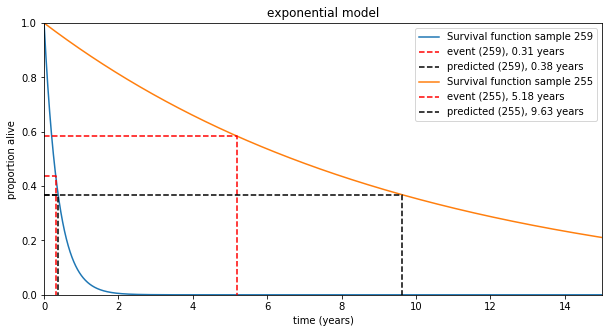

/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays 

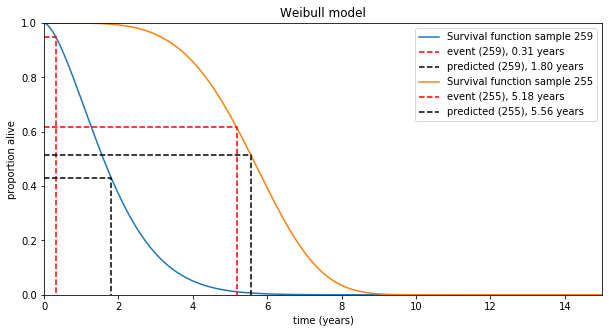

In [9]:
# pick two patients in the test set that experience extreme events
indices = np.squeeze(np.argwhere(np.logical_and(test, osr[:, 1])))
order = np.argsort(osr[indices, 0], axis=0)
samples = [indices[order[int(pct * indices.size)]] for pct in [0.1, 0.9]]


# for plotting survival function, actual and predicted survival
def plot_survival(sample, parameters, event, distribution, time):
    # calculate predicted expected survival
    expected = distribution.expected(parameters)

    # evaluate individualized survival function
    survival = distribution.survival(parameters, time[np.newaxis])

    # plot individualized survival function
    plt.plot(time, survival[0], label="Survival function sample {}".format(sample))

    # for corner plots of time / probability
    def plot_corner(time, probability, label, sample, color):
        plt.plot(
            [0.0, time, time],
            [probability, probability, 0.0],
            label="{} ({}), {:.2f} years".format(label, sample, time),
            linestyle="--",
            color=color,
        )

    # show actual event time
    p_event = distribution.survival(parameters, event)[0]
    plot_corner(event, p_event, "event", sample, "red")

    # show expected / predicted event times
    p_expected = distribution.survival(parameters, expected)[0]
    plot_corner(float(expected), p_expected, "predicted", sample, "black")


# display exponential individualized survival functions
plt.figure(figsize=(10, 5))
for s in samples:
    plot_survival(
        s,
        exponential_model(np.reshape(features[s, :], (1, D))),
        osr[s, 0],
        exponential,
        t_dense,
    )
plt.gca().set_title("exponential model")
plt.gca().set_ylabel("proportion alive")
plt.gca().set_xlabel("time (years)")
plt.xlim((0, 15))
plt.ylim((0, 1))
plt.legend()
plt.show()

# display Weibull individualized survival functions
plt.figure(figsize=(10, 5))
for s in samples:
    parameters, nmedian = weibull_model(np.reshape(features[s, :], (1, D)))
    plot_survival(s, parameters, osr[s, 0], weibull, t_dense)
plt.gca().set_title("Weibull model")
plt.gca().set_ylabel("proportion alive")
plt.gca().set_xlabel("time (years)")
plt.xlim((0, 15))
plt.ylim((0, 1))
plt.legend()
plt.show()

### Evaluating model discrimination

To evaluate model discrimination we can use network predictions to assign samples to prognostic risk categories. For the exponential model, the single *lambda* parameter can be thresholded to determine these groups. A larger *lambda* value will be associated with a worse predicted outcome. Since the Weibull model has two parameters, we can use the `.median` or `.expected` to generate a single representative value for thresholding.

Below we visualize these risk categories using Kaplan-Meier plots. Discriminative power can be evaluated using `survivalnet.metrics.concordance` to measure the rank-order concordance between predicted risks and actual outcomes. While the risk categories are identical for both the exponential and Weibull models, the exponential model has better concordance. This is due to better ranking of risks within categories.

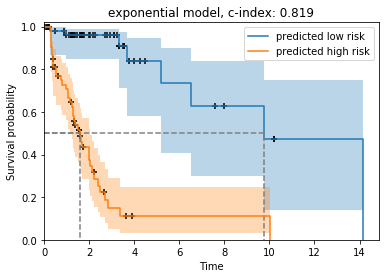

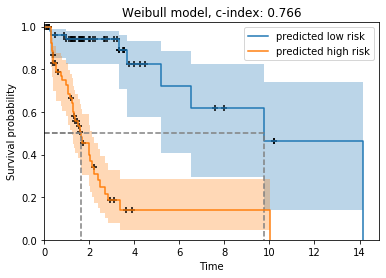

In [10]:
# display model discriminationi statistics
def discrimination(risk, title):
    # assign samples to risk groups
    risk_groups = np.squeeze(np.array(risk > np.median(risk), int)) + 1

    # generate Kaplan-Meier plot
    km_plot(
        np.array(osr[test, :]),
        groups=risk_groups,
        xlabel="Time",
        ylabel="Survival probability",
        legend=["predicted low risk", "predicted high risk"],
    )

    # calculate c-index and set title
    cindex = HarrellsC()
    plt.gca().set_title(
        "{} model, c-index: {:0.3f}".format(title, cindex(osr[test, :], risk))
    )


# evaluate exponential model discrimination
discrimination(exponential_model(features[test, :]), "exponential")

# calculate risks as median survival of individualized distributions
parameters, nmedian = weibull_model(features[test, :])

# evaluate Weibull model calibration
discrimination(nmedian, "Weibull")

### Evaluating model calibration

Since parametric models predict individualized survival functions we can also measure *calibration*, or the agreement between these functions and observed event rates. For example, for a well calibrated model we would expect 10% of the events to occur in the 0-10%-tile of each survival function, etc.

SurvivalNet provides several metrics for evaluating calibration: 1. Brier score 2. Integrated Brier Score and 2. D-calibration (see reference). Brier score measures both discrimination and calibration, and can be calculated for a single time, or integrated over a range of times. D-calibration is purely a calibration metric, and provides a single summary statistic for all time. The D-calibration metric output is a chi-square statistic that can tested for significant difference from an ideally calibrated model.

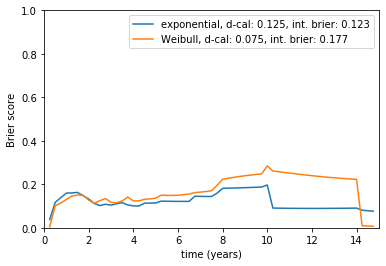

In [11]:
# display model calibration statistics
def calibration(outcomes, parameters, distribution, times, axes, title):
    # calculate d-calibration - measures calibration for all times
    d = Dcal(distribution.survival)(outcomes, parameters)

    # calculate an integrated Brier score across time points
    integrated = IntegratedBrier(outcomes, distribution.survival, times)(
        outcomes, parameters
    )

    # calculate Brier score over a range of times
    scores = [
        Brier(outcomes, distribution.survival, t)(outcomes, parameters) for t in times
    ]

    # plot brier score over time
    label = "{}, d-cal: {:0.3f}, int. brier: {:0.3f}".format(title, d, integrated)
    axes.plot(times, scores, label=label)
    axes.set_xlabel("time (years)")
    axes.set_ylabel("Brier score")
    axes.set_xlim(0, 15)
    axes.set_ylim(0, 1)
    axes.legend()


# generate a coarse time sequence for calculating Brier score
t_coarse = np.arange(0.25, 15, 0.25)

# plot results on a single plot
fig, axs = plt.subplots(1, 1)

# evaluate exponential model calibration
calibration(
    osr[test, :],
    exponential_model(features[test, :]),
    exponential,
    t_coarse,
    axs,
    "exponential",
)

# evaluate Weibull model calibration
calibration(
    osr[test, :], weibull_model(features[test, :])[0], weibull, t_coarse, axs, "Weibull"
)